In [37]:
import torch
import torch.nn as nn
from torch import optim
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

import copy
import time

plt.ion()

In [7]:
train_transform = transforms.Compose([
        transforms.RandomResizedCrop(28),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])
test_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [10]:
train_dataset = datasets.CIFAR10(root='./data', train=True, transform=train_transform, download=True)
test_dataset = datasets.CIFAR10(root='./data', train=False, transform=test_transform, download=True)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


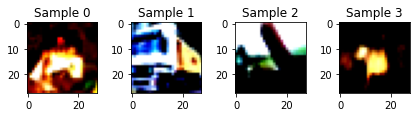

In [21]:
fig = plt.figure()

num_show = 4
for i in range(num_show):
    sample = train_dataset[i]
    ax = plt.subplot(1, num_show, i+1)
    plt.tight_layout()
    ax.set_title("Sample "+str(i))
    plt.imshow(sample[0].permute(1, 2, 0))

In [18]:
classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

In [33]:
batch_size = 4
num_workers = 4
learning_rate = 0.003
num_epochs = 20
shuffle_train_loader = True

In [27]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle_train_loader, num_workers=num_workers)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, num_workers=num_workers)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [30]:
model = models.resnet101(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth


  0%|          | 0.00/171M [00:00<?, ?B/s]

In [34]:
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

In [36]:
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [ ]:
train_size = len(train_dataloader)
test_size = len(test_dataloader)

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs):
    start_train_time = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch+1, num_epochs))
        print('-'*10)
        
        model.train()
        running_loss = 0.0
        running_corrects = 0

        for i, (images, targets) in enumerate(train_dataloader):
            
            images = images.to(device)
            targets = targets.to(device)
            
            optimizer.zero_grad()

            with torch.set_grad_enable(True):
                outputs = model(images)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, targets)
            
            running_loss += loss.item() * images.size[0]
            running_corrects += torch.sum(preds == targets)

        scheduler.step()
    
        epoch_loss = running_loss / train_size
        epoch_acc = running_corrects / train_size
        print('{} Loss: {:.4f} Acc: {:.4f}'.format('Train', epoch_loss, epoch_acc))

        model.eval()
        running_loss = 0.0
        running_corrects = 0

        for i, (images, targets) in enumerate(test_dataloader):

            images = images.to(device)
            targets = targets.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enable(False):
                outputs = model(images)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, targets)

            running_loss += loss.imte() * images.size[0]
            running_corrects += torch.sum(preds == targets)

        epoch_loss = running_loss / train_size
        epoch_acc = running_corrects / train_size
        print('{} Loss: {:.4f} Acc: {:.4f}'.format('Train', epoch_loss, epoch_acc))
        
        if epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            
        print()

    time_elapsed = time.time() - strat_train_time
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    return model
